# This notebook is meant to research denoising techniques for the already cropped receipt images.

The receipt images show various types of noise, such as:
- Shadows
- Wrinkles
- Blurry text
- etc.

Perhaps we can apply some denoising techniques to improve OCR results that are to come.

There are many denoising techniques available. We will of course not test them all, but we can try a few and see if they help.

We could try some "physical" denoising techniques (filtering, morphological operations, etc.), some statistical denoising techniques (like PCA-based denoising) as well as some "deep learning" denoising techniques (like Denoising Autoencoders).

In [1]:
import os, sys
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

sys.path.append(os.path.abspath(os.path.join('../data')))
sys.path.append(os.path.abspath(os.path.join('..')))

---

## Assessing the effect of blurred components in the images

In [2]:
# Loading an image

cropped_images_dir = "../data/_debug/"
image_filenames = os.listdir(cropped_images_dir)

print(f"Number of cropped images available for denoising exmperiments: {len(image_filenames)}")

Number of cropped images available for denoising exmperiments: 100


---

### Removing the wrinkles from the images

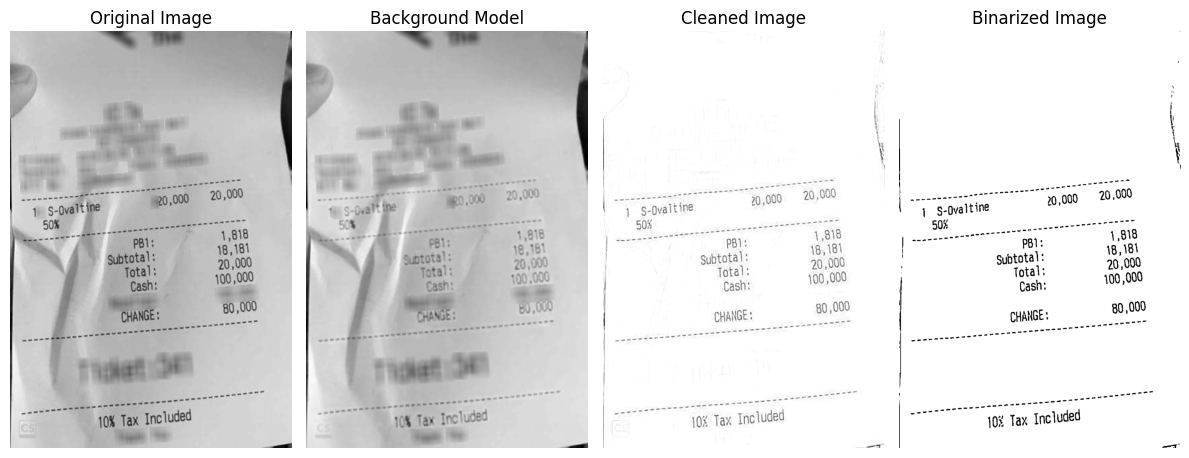

In [ ]:
def lighten_wrinkles(image_path, output_path=None):
    # 1. Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found")

    # Step 2. we define the kernel (structuring element)
    # (5, 5): we choose a kernel size to cover wrinkles effectively - and capture the background (logo, paper texture)
    # but without being too large and losing local variations (text!)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    # Step 3. Morphological Closing
    # removes the dark text, leaving only the background (paper + wrinkles)
    background_model = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    
    # Slight blur on background to reduce artifacts
    background_model = cv2.GaussianBlur(background_model, (5, 5), 0)

    # Step 4. Division Normalization ("De-wrinkling" step)
    # We convert to float to avoid integer overflow issues during division
    result = img.astype(float) / background_model.astype(float)
    
    # Scale back to 0-255 range
    result = result * 255
    result = np.clip(result, 0, 255).astype(np.uint8)

    # Step 5. Binarization
    # Once wrinkles are gone, Otsu's thresholding works much better
    _, binary = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Visualization
    if output_path:
        cv2.imwrite(output_path, result)
        
    return img, background_model, result, binary


# create lighten image function that takes a Matlike image as input and returns the lightened image
def lighten_image(mat_image, output_path=None):
    # Step 2. we define the kernel (structuring element)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

    # Step 3. Morphological Closing
    background_model = cv2.morphologyEx(mat_image, cv2.MORPH_CLOSE, kernel)
    
    # Slight blur on background to reduce artifacts
    background_model = cv2.GaussianBlur(background_model, (5, 5), 0)

    # Step 4. Division Normalization ("De-wrinkling" step)
    result = mat_image.astype(float) / background_model.astype(float)
    
    # Scale back to 0-255 range
    result = result * 255
    result = np.clip(result, 0, 255).astype(np.uint8)

    # Step 5. Binarization
    _, binary = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Step 6. Save output if path is provided
    if output_path:
        cv2.imwrite(output_path, result)
    
    return mat_image, background_model, result, binary

# --- Usage ---
image_path = '../data/_debug/dev_receipt_00002.png' # Replace with your image
original, bg, cleaned, binary = lighten_wrinkles(image_path)

# Display results side-by-side using Matplotlib for analysis
plt.figure(figsize=(12, 8))
plt.subplot(1, 4, 1)
plt.title('Original Image')
plt.imshow(original, cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.title('Background Model')
plt.imshow(bg, cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.title('Cleaned Image')
plt.imshow(cleaned, cmap='gray')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.title('Binarized Image')
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

Detected Skew Angle: -3.95 degrees


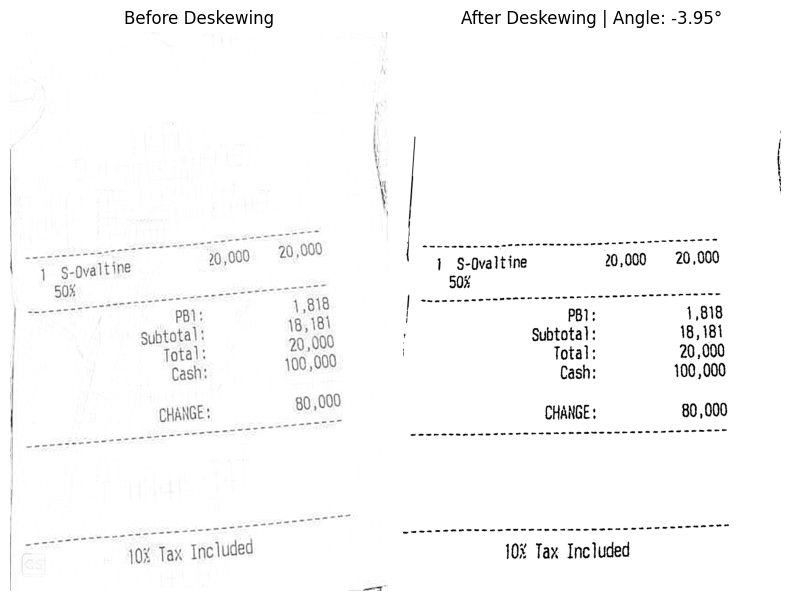

In [13]:
def compute_skew_angle(binary_image):
    # Step 1. Invert image (Background must be black, text white for contours)
    # 127 is mid-gray threshold - usual value to start with
    if binary_image[0, 0] > 127:
        inverted = cv2.bitwise_not(binary_image)
    else:
        inverted = binary_image

    # Step 2. Dilate to connect text into lines
    # Kernel: Wide and short. (20, 1) connects words horizontally.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    dilated = cv2.dilate(inverted, kernel, iterations=1)

    # Step 3. Find Contours of the text lines
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    angles = []
    for contour in contours:
        # Filter small noise (dots, specks)
        if cv2.contourArea(contour) < 100: 
            continue
            
        # Fit a rotated rectangle
        rect = cv2.minAreaRect(contour) 
        # rect = ((center_x, center_y), (width, height), angle)
        (center, (w, h), angle) = rect
        
        # Step 4. Correct the angle based on rectangle orientation
        # We normalize to ensure the angle represents the horizontal axis deviation.
        
        if w < h:
            # If width is less than height, the angle corresponds to the vertical side.
            # We shift it by 90 degrees to get the horizontal alignment.
            angle = angle - 90
            
        angles.append(angle)

    # Step 5. Determine the median angle (Robust to outliers)
    if len(angles) > 0:
        median_angle = np.median(angles)
    else:
        median_angle = 0.0

    return median_angle

def rotate_image(image, angle):
    # Get image center
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Compute rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Perform the rotation
    # borderValue=(255,255,255) fills the new empty corners with white
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
    
    return rotated

skew_angle = compute_skew_angle(binary)
print(f"Detected Skew Angle: {skew_angle:.2f} degrees")

# Rotate the original (cleaned) image, not just the binary one
deskewed_image = rotate_image(binary, skew_angle)

# Visualization
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
plt.title('Before Deskewing')
plt.imshow(cleaned, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title(f'After Deskewing | Angle: {skew_angle:.2f}°')
plt.imshow(deskewed_image, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()